# Rasdaman Data Access - First Tries

In [1]:
# this notebook uses dotenv to retrieve secrets from environment variables
# get it with: pip install python-dotenv

%load_ext dotenv
%dotenv

In [2]:
import os

# read the secret information ...
#   Create a .env file in the notebooks folder first that has entries like:
#
#   RASDAMAN_SERVICE_ENDPOINT=<url>
#   RASDAMAN_CRED_USERNAME=<rasdaman_endpoint_username>
#   RASDAMAN_CRED_PASSWORD=<rasdaman_endpoint_password>
#   etc.

rasdaman_username = os.getenv("RASDAMAN_CRED_USERNAME")
rasdaman_password = os.getenv("RASDAMAN_CRED_PASSWORD")
rasdaman_endpoint = os.getenv("RASDAMAN_SERVICE_ENDPOINT")

base_wcs_url = rasdaman_endpoint + "?service=WCS&version=2.1.0"

## WCS

In [3]:
import requests
import xmltodict

# describe the WCS
response = requests.get(base_wcs_url + "&request=GetCapabilities", auth=(rasdaman_username, rasdaman_password))
wcs_data = xmltodict.parse(response.content)
wcs_data

{'wcs:Capabilities': {'@version': '2.1.0',
  '@xsi:schemaLocation': 'http://www.opengis.net/wcs/2.1 http://schemas.opengis.net/wcs/2.1/wcsGetCapabilities.xsd',
  '@xmlns:wcs': 'http://www.opengis.net/wcs/2.1',
  '@xmlns:xsi': 'http://www.w3.org/2001/XMLSchema-instance',
  '@xmlns:gml': 'http://www.opengis.net/gml/3.2',
  '@xmlns:swe': 'http://www.opengis.net/swe/2.0',
  '@xmlns:ows': 'http://www.opengis.net/ows/2.0',
  '@xmlns:xlink': 'http://www.w3.org/1999/xlink',
  '@xmlns:rasdaman': 'http://www.rasdaman.org',
  '@xmlns:int': 'http://www.opengis.net/wcs/interpolation/1.0',
  '@xmlns:crs': 'http://www.opengis.net/wcs/service-extension/crs/1.0',
  '@xmlns:inspire_dls': 'http://inspire.ec.europa.eu/schemas/inspire_dls/1.0',
  '@xmlns:inspire_common': 'http://inspire.ec.europa.eu/schemas/common/1.0',
  'ows:ServiceIdentification': {'ows:Title': 'rasdaman',
   'ows:Abstract': 'rasdaman server - free download from www.rasdaman.org',
   'ows:ServiceType': 'OGC WCS',
   'ows:ServiceTypeVers

In [4]:
# list the WCS contents
wcs_contents = wcs_data['wcs:Capabilities']['wcs:Contents']['wcs:CoverageSummary']
wcs_contents

{'wcs:CoverageId': 'imperviousness',
 'wcs:CoverageSubtype': 'RectifiedGridCoverage',
 'ows:WGS84BoundingBox': {'ows:LowerCorner': '-27.3444 27.0428',
  'ows:UpperCorner': '35.4948 72.2158'},
 'ows:BoundingBox': {'@crs': 'http://localhost:8080/rasdaman/def/crs/EPSG/0/4326',
  '@dimensions': '2',
  'ows:LowerCorner': '27.04280000000000 -27.3444',
  'ows:UpperCorner': '72.2158 35.4948'},
 'ows:AdditionalParameters': {'ows:AdditionalParameter': [{'ows:Name': 'sizeInBytes',
    'ows:Value': '283863518160'},
   {'ows:Name': 'sizeInBytesWithPyramidLevels', 'ows:Value': '307495836610'},
   {'ows:Name': 'axisList', 'ows:Value': 'Lat,Lon'}]}}

In [5]:
cov_id = "&COVERAGEID=" + wcs_contents['wcs:CoverageId']
encode_format = "&FORMAT=tiff"

# Sandefjord region
subset_lat = "&subset=Lat(59.10, 59.20)"
subset_long = "&subset=Long(10.20, 10.30)"

response = requests.get(
    base_wcs_url + "&request=GetCoverage" + cov_id + subset_long + subset_lat + encode_format,
    auth=(rasdaman_username, rasdaman_password),
    verify=False)

# response.content

/vsimem/93563207-bfd5-41ef-bde5-7d70b4bdc018/93563207-bfd5-41ef-bde5-7d70b4bdc018.tif 1 1000 1000
BoundingBox(left=10.2, bottom=59.1, right=10.3, top=59.2)


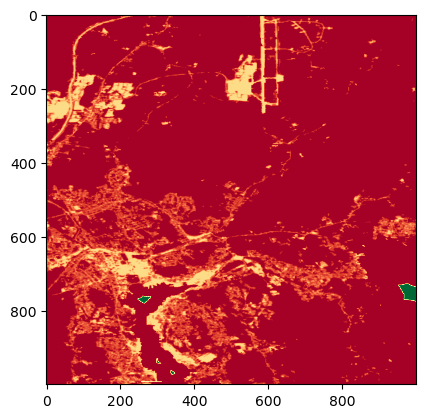

In [22]:
from matplotlib import pyplot
from rasterio.io import MemoryFile
from rasterio.plot import show_hist

with MemoryFile(response.content) as memfile:
    with memfile.open() as ds:
        print(ds.name, ds.count, ds.width, ds.height)
        print(ds.bounds)
        ds_array = ds.read(1)
        # show_hist(ds_array, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled')
        pyplot.imshow(ds_array, cmap='RdYlGn')
